In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
import calendar
import os
import pprint
from elasticsearch import Elasticsearch
from fastai import *
from fastai.collab import *
from fastai.tabular import *
import dtale
%matplotlib inline
pd.set_option('display.max_columns', None)

In [63]:
path = 'C:\\Users\\bokhy\\Desktop\\ATG'
df = pd.read_csv(os.path.join(path, 'Chiropractics.csv'))

In [64]:
# Select preferred time zone to present timestamps
TIMEZONE = 'America/New_York'
TIMEZONE = 'America/Los_Angeles'
TIMEZONE = 'Asia/Taipei'
TIMEZONE = 'utc'

In [65]:
# Add_service
df['service'] = ['Built-in 350' if x<10000 else ('BYOG' if x< 10000000 else ('ArcadeNet' if x>= 10000000 else 'N/A')) for x in df['activity.game_id']]

In [74]:
df.head()

,@timestamp,account.email,activity.1p_buttons,activity.1p_joystick,activity.1p_spinner,activity.2p_buttons,activity.2p_joystick,activity.2p_spinner,activity.game_id,activity.game_title,activity.log_at,activity.play_duration,day,hour,log_type,machine_uuid,minute,month,play_end,play_start,playtime,second,service,weekday,year
17,"Mar 9, 2020 @ 16:21:06.434",atgames.qa+bent@gmail.com,150.0,406.0,982.0,94.0,278.0,2082.0,448.0,Tetris® Plus,NaN,1897.0,9.0,15.0,game-play,88001911B0019068,49.0,3.0,2020-03-09 16:21:06.067000+00:00,2020-03-09 15:49:29.302000+00:00,00:31:36.765000,29.0,Built-in 350,Monday,2020.0
18,"Mar 6, 2020 @ 10:24:46.431",atgames.qa+bent@gmail.com,5.0,30.0,682.0,3.0,30.0,684.0,418.0,Aladdin,NaN,2395.0,6.0,9.0,game-play,88001911B0019068,44.0,3.0,2020-03-06 10:24:45.349000+00:00,2020-03-06 09:44:50.336000+00:00,00:39:55.013000,50.0,Built-in 350,Friday,2020.0
19,"Mar 6, 2020 @ 08:11:54.580",atgames.qa+bent@gmail.com,172.0,105.0,823.0,0.0,0.0,167.0,413.0,"Fix-It Felix, Jr.",NaN,125.0,6.0,8.0,game-play,88001911B0019068,9.0,3.0,2020-03-06 08:11:53.850000+00:00,2020-03-06 08:09:48.261000+00:00,00:02:05.589000,48.0,Built-in 350,Friday,2020.0
20,"Mar 6, 2020 @ 08:11:54.580",atgames.qa+bent@gmail.com,2.0,0.0,3.0,0.0,0.0,3.0,422.0,The Lion King,NaN,8.0,6.0,8.0,game-play,88001911B0019068,11.0,3.0,2020-03-06 08:11:53.860000+00:00,2020-03-06 08:11:45.884000+00:00,00:00:07.976000,45.0,Built-in 350,Friday,2020.0
21,"Mar 6, 2020 @ 07:19:42.216",atgames.qa+bent@gmail.com,5.0,0.0,143.0,1.0,0.0,0.0,62.0,Breakout® (2600),NaN,21.0,6.0,7.0,game-play,88001911B0019068,19.0,3.0,2020-03-06 07:19:41.413000+00:00,2020-03-06 07:19:20.714000+00:00,00:00:20.699000,20.0,Built-in 350,Friday,2020.0


In [67]:
# Split into two for datetime accu
df1 = df[df.log_type == 'game-play']
df2 = df[df.log_type == 'Game']

In [68]:
df1.shape

(66, 19)

In [69]:
df2.shape

(10, 19)

In [70]:
# Cabinets < 4.10.0
def Preprocess1(df):
    df['log.timestamp'] = pd.DatetimeIndex(pd.to_datetime(df['log.timestamp'],format="%b %d, %Y @ %H:%M:%S.%f"),tz = TIMEZONE)
    df['activity.play_start'] = pd.DatetimeIndex(pd.to_datetime(df['activity.play_start'],format="%b %d, %Y @ %H:%M:%S.%f"),tz = TIMEZONE)
    df['activity.play_end'] = pd.DatetimeIndex(pd.to_datetime(df['activity.play_end'],format="%b %d, %Y @ %H:%M:%S.%f"),tz = TIMEZONE)
    df['playtime'] = df['activity.play_end'] - df['activity.play_start'] 
    df = df.rename(columns={"log.timestamp": "play_end"})
    df['play_start'] = df['play_end'] - df['playtime']
    df['weekday'] = df['play_start'].dt.day_name()
    df['year'] = df['play_start'].dt.year
    df['month'] = df['play_start'].dt.month
#    df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])
    df['day'] = df['play_start'].dt.day
    df['hour'] = df['play_start'].dt.hour
    df['minute'] = df['play_start'].dt.minute
    df['second'] = df['play_start'].dt.second
#    df['date'] = df["month"]+ "-" + df["day"].map(str)
    df = df.drop(['activity.play_start','activity.play_end','log_at'], axis=1)
    return df

# Cabinets >= 4.10.0
def Preprocess2(df):
    df['activity.play_start'] = pd.DatetimeIndex(pd.to_datetime(df['activity.play_start'],format="%b %d, %Y @ %H:%M:%S.%f"),tz = TIMEZONE)
    df['activity.play_end'] = pd.DatetimeIndex(pd.to_datetime(df['activity.play_end'],format="%b %d, %Y @ %H:%M:%S.%f"),tz = TIMEZONE)
    df['playtime'] = df['activity.play_end'] - df['activity.play_start'] 
    df = df.rename(columns={"activity.play_start": "play_start","activity.play_end": "play_end"})
    df['weekday'] = df['play_start'].dt.day_name()
    df['year'] = df['play_start'].dt.year
    df['month'] = df['play_start'].dt.month
#    df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])
    df['day'] = df['play_start'].dt.day
    df['hour'] = df['play_start'].dt.hour
    df['minute'] = df['play_start'].dt.minute
    df['second'] = df['play_start'].dt.second
#    df['date'] = df["month"]+ "-" + df["day"].map(str)
    df = df.drop(['log.timestamp','log_at'], axis=1)
    return df

def Numericalize(df):
    cols = ['activity.play_duration','activity.1p_buttons','activity.1p_joystick','activity.1p_spinner',
           'activity.2p_buttons','activity.2p_spinner'] #'activity.2p_joystick'
    for i in cols:
        df[i] = df[i].str.replace(",","").astype(float)
        df[i] = df[i].apply(pd.to_numeric)
    return df

In [71]:
df1 = Preprocess1(df1)

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [72]:
df2 = Preprocess2(df2)

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [73]:
df = df1.append(df2)
df = df.sort_values("@timestamp",ascending=False)
df = Numericalize(df)

# Plots

In [268]:
df_new = df.groupby('activity.game_title').agg({'playtime': 'sum','activity.1p_buttons': 'sum','activity.1p_joystick': 'sum','activity.1p_spinner': 'sum',
                                               'activity.2p_buttons': 'sum','activity.2p_joystick': 'sum','activity.2p_spinner': 'sum'}).sort_values('playtime', ascending=False).rename(columns={'playtime': 'Playtime(Hours)'})
df_new = df_new.reset_index().sort_values('Playtime(Hours)', ascending=False)

In [270]:
df_new.round(2)

,activity.game_title,Playtime(Hours),activity.1p_buttons,activity.1p_joystick,activity.1p_spinner,activity.2p_buttons,activity.2p_joystick,activity.2p_spinner
0,Aladdin,1.38,755.0,1242.0,5390.0,8.0,116,2761.0
1,Asteroids® (Arcade),0.95,7009.0,6806.0,52607.0,1529.0,1305,45300.0
2,Tetris® Plus,0.59,211.0,514.0,988.0,94.0,278,2084.0
3,Asteroids® (2600),0.47,942.0,405.0,124.0,0.0,26,140.0
4,Super Star Wars: Return of the Jedi,0.46,251.0,825.0,2289.0,27.0,31,4945.0
5,The Lion King,0.41,851.0,728.0,5919.0,0.0,0,2400.0
6,Sprint (Arcade),0.32,13.0,81.0,765.0,0.0,0,92.0
7,BurgerTime™ (Arcade),0.24,155.0,484.0,912.0,9.0,19,400.0
8,"Fix-It Felix, Jr.",0.10,313.0,263.0,1839.0,19.0,73,852.0
9,Tetris® Plus 2,0.07,21.0,9.0,424.0,32.0,89,687.0


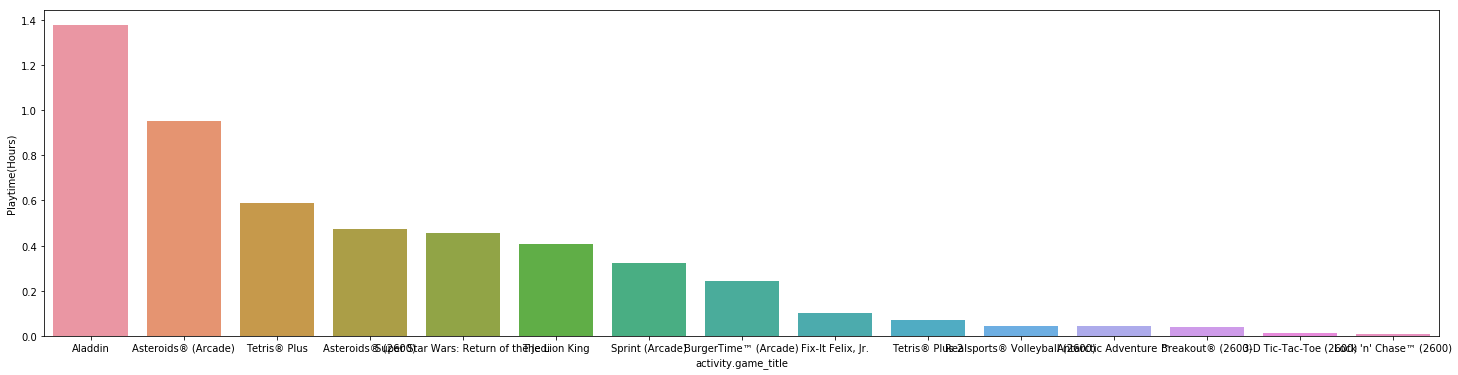

In [271]:
f, ax = plt.subplots(figsize=(25, 6))
sns.barplot(x='activity.game_title', y='Playtime(Hours)' , data=df_new)

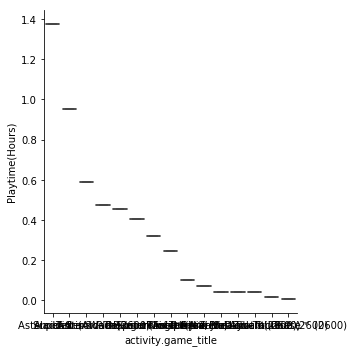

In [275]:
sns.catplot(x="activity.game_title", y="Playtime(Hours)",
                data=df_new, kind="box")

In [ ]:
sns.catplot(x="hour", y="Weekdays",
                hue="machine_uuid", col="service",
                data=df, kind="box")

In [ ]:
sns.catplot(x="Weekdays",
                hue="service", col="service",col_wrap=4,
                data=df, kind="count")

### TOP played game

In [261]:
def Top_Playing(df):
    df = df.groupby('activity.game_title').agg({'playtime': 'count'}).rename(columns={'playtime': 'Counts'})
    df = df.reset_index().sort_values('Counts', ascending=False).reset_index(drop=True)[['activity.game_title', 'Counts']]
    return df

In [262]:
top = Top_Playing(df)

In [263]:
top.head()

,activity.game_title,Counts
0,Aladdin,5
1,Asteroids® (Arcade),3
2,"Fix-It Felix, Jr.",3
3,Super Star Wars: Return of the Jedi,3
4,The Lion King,3


# Button / Joystick / Spinner Frequency

In [258]:
def Second_Player(df):
    df = df.groupby('activity.game_title').agg({'activity.1p_buttons':'sum','activity.1p_joystick':'sum','activity.1p_spinner':'sum',
                                        'activity.2p_buttons':'sum','activity.2p_joystick':'sum','activity.2p_spinner':'sum'})#.rename(columns={'played_time': 'total_played_time'})
    df = df.reset_index().sort_values('activity.2p_buttons', ascending=False).reset_index(drop=True)
    return df

In [259]:
second_player = Second_Player(df)

In [260]:
second_player

,activity.game_title,activity.1p_buttons,activity.1p_joystick,activity.1p_spinner,activity.2p_buttons,activity.2p_joystick,activity.2p_spinner
0,Asteroids® (Arcade),7009.0,6806.0,52607.0,1529.0,1305,45300.0
1,Tetris® Plus,211.0,514.0,988.0,94.0,278,2084.0
2,3-D Tic-Tac-Toe (2600),12.0,41.0,41.0,36.0,1,0.0
3,Tetris® Plus 2,21.0,9.0,424.0,32.0,89,687.0
4,Realsports® Volleyball (2600),9.0,203.0,538.0,31.0,0,2001.0
5,Super Star Wars: Return of the Jedi,251.0,825.0,2289.0,27.0,31,4945.0
6,"Fix-It Felix, Jr.",313.0,263.0,1839.0,19.0,73,852.0
7,Breakout® (2600),30.0,2.0,1597.0,15.0,4,980.0
8,BurgerTime™ (Arcade),155.0,484.0,912.0,9.0,19,400.0
9,Aladdin,755.0,1242.0,5390.0,8.0,116,2761.0
